In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Baseline model

In [2]:
df = pd.read_csv('data_clean.csv')

In [3]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(y_train.mean(), y_test.mean())

0.21526875 0.2152625


In [4]:
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = [('te',TargetEncoder()),('sc',StandardScaler()),('lr',LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=500,
    C= 0.05))]

pipe = Pipeline(pipeline)

pipe.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder()), ('sc', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.05, class_weight='balanced',
                                    max_iter=500, penalty='l1',
                                    solver='liblinear'))])

In [5]:
from sklearn.metrics import roc_auc_score, log_loss

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

logloss = log_loss(y_test, y_pred_proba)


print("Baseline ROC-AUC:", auc)
print("Baseline logloss:", logloss)

Baseline ROC-AUC: 0.7209846745203681
Baseline logloss: 0.6164114643301151


In [6]:
comparison = {'model':['Logistic Regression', 'XGB_default', 'XGB_opt', 'XGB_post_calibration'],'AUC':[], 'log_loss':[]}
comparison['AUC'].append(auc)
comparison['log_loss'].append(logloss)

Coefficient inspection

In [7]:
log_reg = pipe.named_steps.lr

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": log_reg.coef_[0]
})


coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False)

In [8]:
coef_df.head(20)

,feature,coef
70,term_num,0.262667
4,sub_grade,0.249275
1,int_rate,0.157989
84,pymnt_plan_y,0.147766
33,acc_open_past_24mths,0.147020
43,mort_acc,0.125339
5,home_ownership,0.105153
71,avg_fico,0.094379
69,emp_length_num,0.090232
49,num_actv_rev_tl,0.080814


In [9]:
(coef_df["coef"] == 0).mean()

np.float64(0.03333333333333333)

l1 penalty set coefficients of about 2% features to 0

## XGBoost + SHAP

We keep sub_grade, drop grade

sub_grade already contains grade information

Reduces redundancy and noise

In [10]:
X = df.drop(columns=["loan_status", "grade"], errors="ignore")
y = df["loan_status"]

In [11]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [12]:
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])

pipeline2 = [('te',TargetEncoder()), ('sc', StandardScaler()), ('xgb', XGBClassifier(
    n_estimators=200,
    max_depth=5,
    min_child_weight=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    eval_metric="auc",
    random_state=42
))]

pipe_xgb = Pipeline(pipeline2)

pipe_xgb.fit(X_train, y_train)


Pipeline(steps=[('te', TargetEncoder()), ('sc', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=50, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Model Evaluation

In [13]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe_xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

logloss = log_loss(y_test, y_pred_proba)

print("XGBoost ROC-AUC:", auc)
print("logloss:", logloss)



XGBoost ROC-AUC: 0.7272206545377753
logloss: 0.6061871331937595


In [14]:
comparison['AUC'].append(auc)
comparison['log_loss'].append(logloss)

## KS statistic

In [15]:
import numpy as np
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_pred_proba[y_test == 0],
    y_pred_proba[y_test == 1]
).statistic

print("KS:", ks)

KS: 0.3326933875813176


## SHAP: Explainability

In [16]:
import shap

X_test_transformed = pipe_xgb[:-1].transform(X_test.iloc[:500])

model = pipe_xgb.named_steps.xgb


In [17]:
X_test_transformed.shape

(500, 89)

In [18]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=X.columns)
X_test_transformed_df.shape

(500, 89)

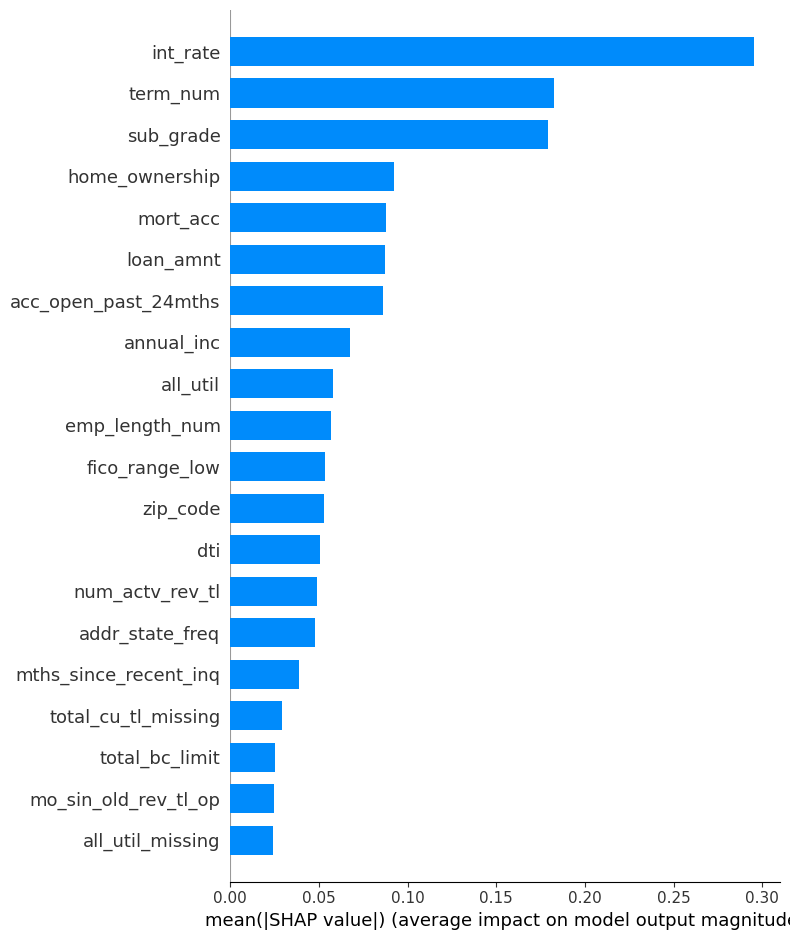

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed_df)


shap.summary_plot(shap_values, X_test_transformed_df, plot_type='bar')

## Directional Understanding

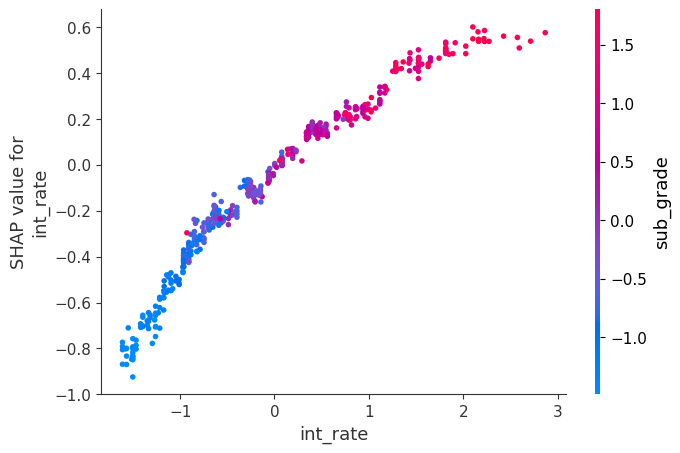

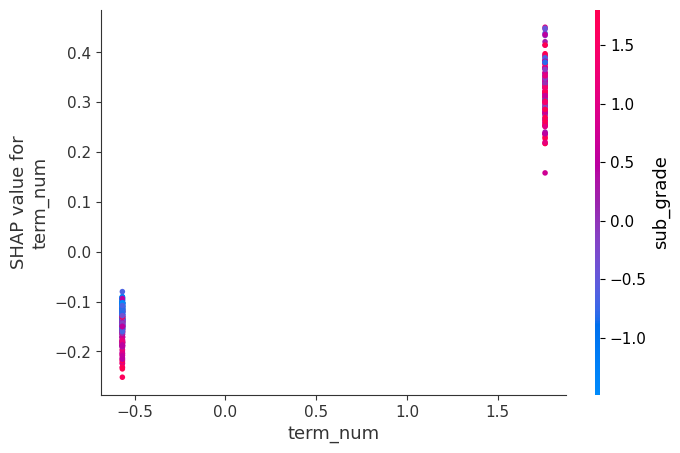

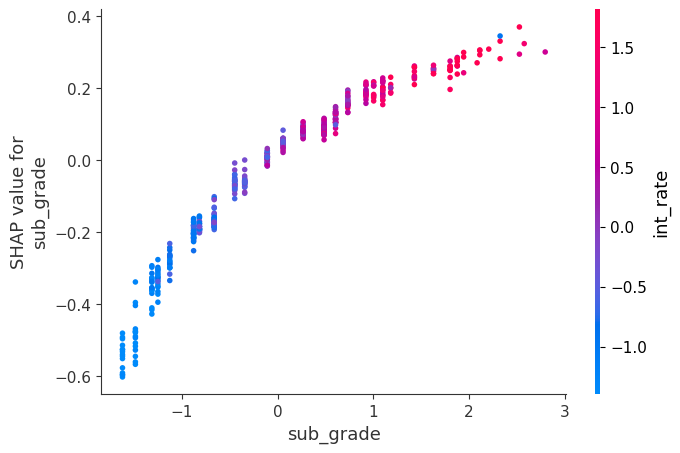

In [20]:
shap.dependence_plot("int_rate", shap_values, X_test_transformed_df)
shap.dependence_plot("term_num", shap_values, X_test_transformed_df)
shap.dependence_plot("sub_grade", shap_values, X_test_transformed_df)


#### Get SHAP values for one loan

In [21]:
i = 42  # loan index

loan = X_test_transformed_df.iloc[[i]]
shap_vals = explainer.shap_values(loan)

In [22]:
loan_shap = (
    pd.DataFrame({
        "feature": loan.columns,
        "value": loan.values[0,:],
        "shap": shap_vals[0,:]
    })
    .sort_values(by = 'shap', key=np.abs, ascending=False)
)


In [23]:
loan_shap.head(10)

,feature,value,shap
1,int_rate,-1.348263,-0.699212
3,sub_grade,-1.315965,-0.427441
32,acc_open_past_24mths,-0.956433,-0.142576
69,term_num,-0.568077,-0.113866
48,num_actv_rev_tl,-1.063475,-0.106216
10,fico_range_low,-1.488932,-0.094658
5,annual_inc,0.339712,0.087358
4,home_ownership,-0.985671,-0.068698
44,mths_since_recent_inq,-1.770137,-0.057267
2,installment,-1.120009,-0.041556


Let us try to understand above table.

int_rate value is negative means below average so the borrower was offered a relatively low interest rate. This could be because Lender assesed this as low-risk.

sub_grade value is negative means better loan_grade by lender which means lender assessed this as low-risk.

acc_open_past_24mths value is negative which means below average. So not many accounts opened in last 24 months which reflects stable credit behaviour.

term_num value is negative which means a short-term loans. Short-terms loans have relatively lower risk which is reflected in SHAP value.

Almost all strong features push risk DOWN(Because of negative SHAP values)

Only annual income slightly increases risk

Net effect: model sees this as a relatively safer borrower

This borrower is predicted to be low risk primarily due to a low interest rate and strong loan grade, supported by stable credit behavior and manageable repayment obligations. Higher income slightly increases risk, but its impact is negligible compared to the dominant protective factors.

This is because `int_rate, sub_grade, acc_open_past_24mths, term_num` are features having highest impact on SHAP and all have negative SHAP values , ie, reduce risk.

In [24]:
! pip install scikit-optimize

In [25]:
from skopt_hyperparam_tune import *

In [26]:
te = TargetEncoder(
    categories="auto",
    target_type="binary",
    smooth="auto"
)

X_train_te = te.fit_transform(X_train, y_train)

X_test_te = te.transform(X_test)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_te)
X_test_scaled = scaler.transform(X_test_te)



In [28]:

X_train_final = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train.index
)

X_test_final = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns,
    index=X_test.index
)

In [29]:
best_params = tune_xgb_credit_risk_cv(X_train_final, y_train)

final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    random_state=42,
    verbosity=0,
    n_jobs=-1,
    **best_params
)

final_model.fit(X_train_final, y_train)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 142.5551
Function value obtained: 0.5081
Current minimum: 0.5081
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 121.6995
Function value obtained: 0.6949
Current minimum: 0.5081
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 100.1366
Function value obtained: 0.4939
Current minimum: 0.4939
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 148.2372
Function value obtained: 0.5444
Current minimum: 0.4939
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 142.1895
Function value obtained: 0.7649
Current minimum: 0.4939
Iteration No: 6 started. 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08433343959767227,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(6), max_leaves=None,
              min_child_weight=np.int64(20), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [30]:
y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

logloss = log_loss(y_test, y_pred_proba)

print("XGBoost best ROC-AUC:", auc)
print("logloss:", logloss)

XGBoost best ROC-AUC: 0.7281745150804696
logloss: 0.49067875863483007


In [31]:
comparison['AUC'].append(auc)
comparison['log_loss'].append(logloss)

## Probability Calibration

In [32]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

calibrated_model = CalibratedClassifierCV(
    estimator=final_model,
    method="isotonic",
    cv=5
)

calibrated_model.fit(X_train_final, y_train)

# Compare
probs_before = final_model.predict_proba(X_test_final)[:, 1]
probs_after = calibrated_model.predict_proba(X_test_final)[:, 1]

print("Before Calibration:")
print("Log Loss:", log_loss(y_test, probs_before))
print("ROC_AUC Score:", roc_auc_score(y_test, probs_before))

print("\nAfter Calibration:")
print("Log Loss:", log_loss(y_test, probs_after))
print("ROC_AUC Score:", roc_auc_score(y_test, probs_after))

Before Calibration:
Log Loss: 0.49067875863483007
ROC_AUC Score: 0.7281745150804696

After Calibration:
Log Loss: 0.4623317889697199
ROC_AUC Score: 0.7293651834453957


In [33]:
comparison['AUC'].append(roc_auc_score(y_test, probs_after))
comparison['log_loss'].append(log_loss(y_test, probs_after))

In [34]:
comparison = pd.DataFrame(comparison)
comparison.head()

,model,AUC,log_loss
0,Logistic Regression,0.720985,0.616411
1,XGB_default,0.727221,0.606187
2,XGB_opt,0.728175,0.490679
3,XGB_post_calibration,0.729365,0.462332
